In [414]:
from __future__ import annotations
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [415]:
def f(x):
    return 3*x**2 - 4*x +5

In [416]:
f(3.0)

20.0

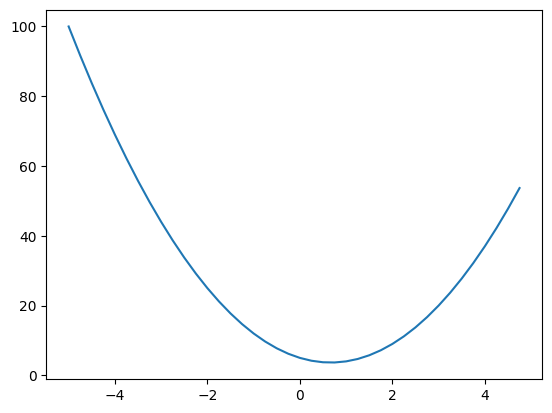

In [417]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [418]:
h = 0.000001
x = 2/3
(f(x + h) - f(x)) / h

2.999378523327323e-06

In [419]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [420]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [421]:
class Value:
    def __init__(self, data: float | int | str, _children: 'tuple[Value]' = (), _op: str ='', label: str =''):
        self.data: float = float(data)
        self.grad: float = 0.0
        self._backward = lambda: None
        self._prev: set[Value] = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, value: float | int | str | 'Value') -> 'Value':
        other: Value = value if isinstance(value, Value) else Value(value)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, value: float | int | str | 'Value') -> 'Value':
        other: Value = value if isinstance(value, Value) else Value(value)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, value: float | int | str | 'Value') -> 'Value':
        return self * value
    
    def __pow__(self, other: float | int) -> 'Value':
        assert isinstance(other, (float, int)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other) -> 'Value':
        return self * other**-1
    
    def __neg__(self) -> 'Value':
        return self * -1

    def __sub__(self, other) -> 'Value':
        return self + (-other)
    
    def tanh(self) -> 'Value':
        x = self.data
        t = (math.exp(2 * x) - 1)/(math.exp(2 * x) + 1) # tanh(x)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad # tanh'(x) = 1 - tanh(x)**2
        out._backward = _backward

        return out

    def exp(self) -> 'Value':
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad # exp'(x) = exp(x)
        out._backward = _backward

        return out

    def backward(self) -> None:
        # Topological sort
        topo: list[Value] = []
        visited: set[Value] = set()
        def build_topo(v: Value):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [422]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [423]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

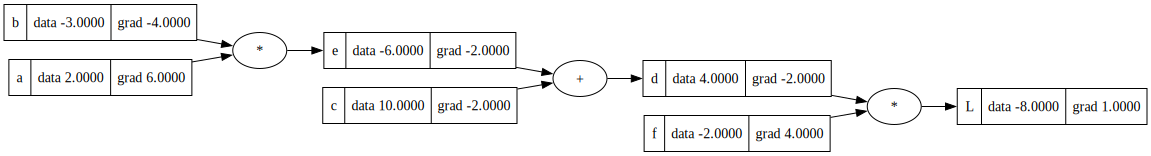

In [424]:
L.backward()
draw_dot(L)

# L.grad = 1.0
# dL / dL = 1.0

# f.grad = 4.0
# d.graf = -2.0
# dL / df = (f * d)' = d = 4.0
# dL / dd = (f * d)' = f = -2.0

# c.grad = -2.0
# e.grad = -2.0
# dL / dc = (dL / dd) * (dd / dc) = -2.0 * (c + e)' = -2.0 * 1.0 = -2.0
# dL / de = (dL / dd) * (dd / de) = -2.0 * (c + e)' = -2.0 * 1.0 = -2.0

# a.grad = 6.0
# b.grad = -4.0
# dL / da = (dL / de) * (de / da) = -2.0 * (a * b)' = -2.0 * b = -2.0 * -3.0 = 6.0
# dL / db = (dL / de) * (de / db) = -2.0 * (a * b)' = -2.0 * a = -2.0 * 2.0 = -4.0

In [425]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


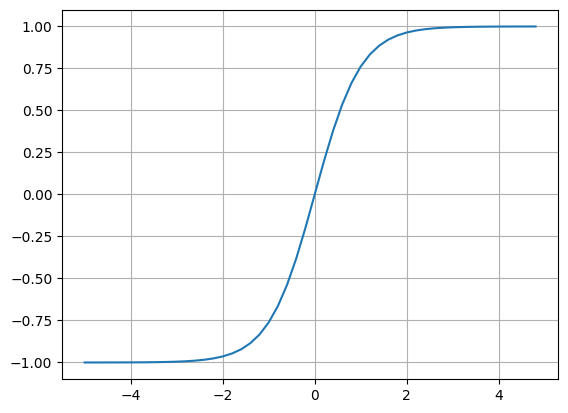

In [426]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [427]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias
b = Value(6.8813735870195432, label='b')

# n = x1*w1 + x2*w2 + b
# o = tanh(n)
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

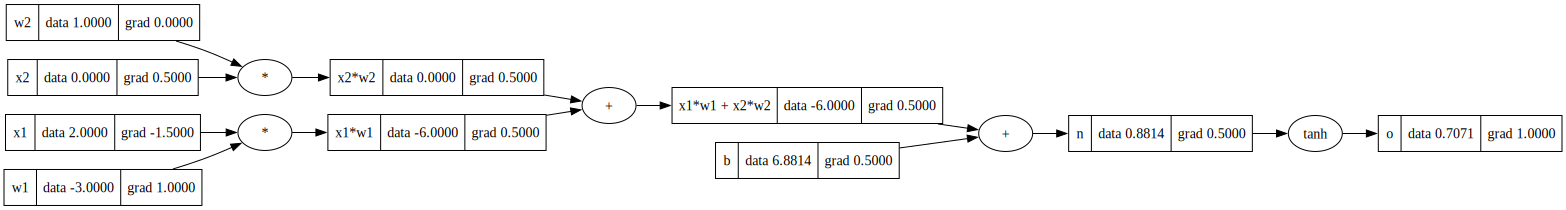

In [428]:
o.backward()
draw_dot(o)

# o.grad = 1.0
# do / do = 1.0

# n.grad = 0.5
# do / dn = tanh(n)' = 1 - tanh(n)**2 = 1 - o**2 = 1 - (0.7071 ** 2) = 0.5

# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# do / dx1w1x2w2 = (do / dn) * (dn / dx1w1x2w2) = 0.5
# do / db = (do / dn) * (dn / db) = 0.5

# x2w2.grad = 0.5
# x1w1.grad = 0.5
# do / dx2w2 = (do / dx1w1x2w2) * (dx1w1x2w2 / dx2w2) = 0.5
# do / dx1w1 = (do / dx1w1x2w2) * (dx1w1x2w2 / dx1w1) = 0.5

# w2.grad = 0.0
# x2.grad = 0.5
# do / dw2 = (do / dx2w2) * (dx2w2 / dw2) = 0.5 * x2 = 0.5 * 0.0 = 0.0
# do / dx2 = (do / dx2w2) * (dx2w2 / dx2) = 0.5 * w2 = 0.5 * 1.0 = 0.5
# w1.grad = 1.0
# x1.grad = -1.5
# do / dw1 = (do / dx1w1) * (dx1w1 / dw1) = 0.5 * x1 = 0.5 * 2.0 = 1.0
# do / dx1 = (do / dx1w1) * (dx1w1 / dx1) = 0.5 * w1 = 0.5 * -3.0 = -1.5

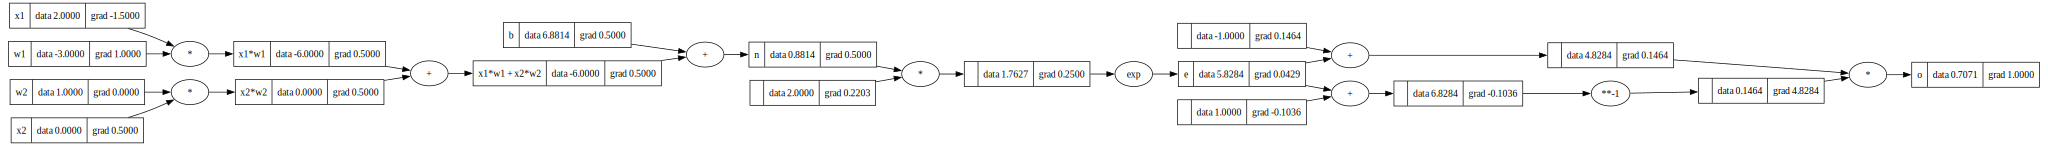

In [429]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias
b = Value(6.8813735870195432, label='b')

# n = x1*w1 + x2*w2 + b
# o = tanh(n) = (e^2n - 1) / (e^2n + 1)
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2 * n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'

o.backward()
draw_dot(o)

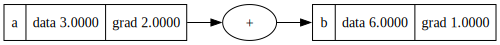

In [430]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'

b.backward()
draw_dot(b)

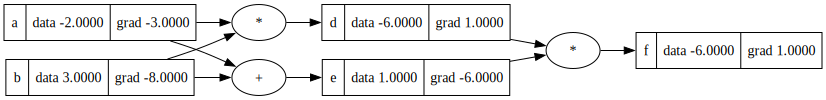

In [431]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)

In [432]:
import torch

# Inputs
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
# Weights
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
# Bias
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [433]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    

# Multilayer Perceptron
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [434]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.4906641273901909)

In [435]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.4118530385568544),
 Value(data=-0.9992113204246544),
 Value(data=0.5692589628003047)]

In [436]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.24064559785990544)

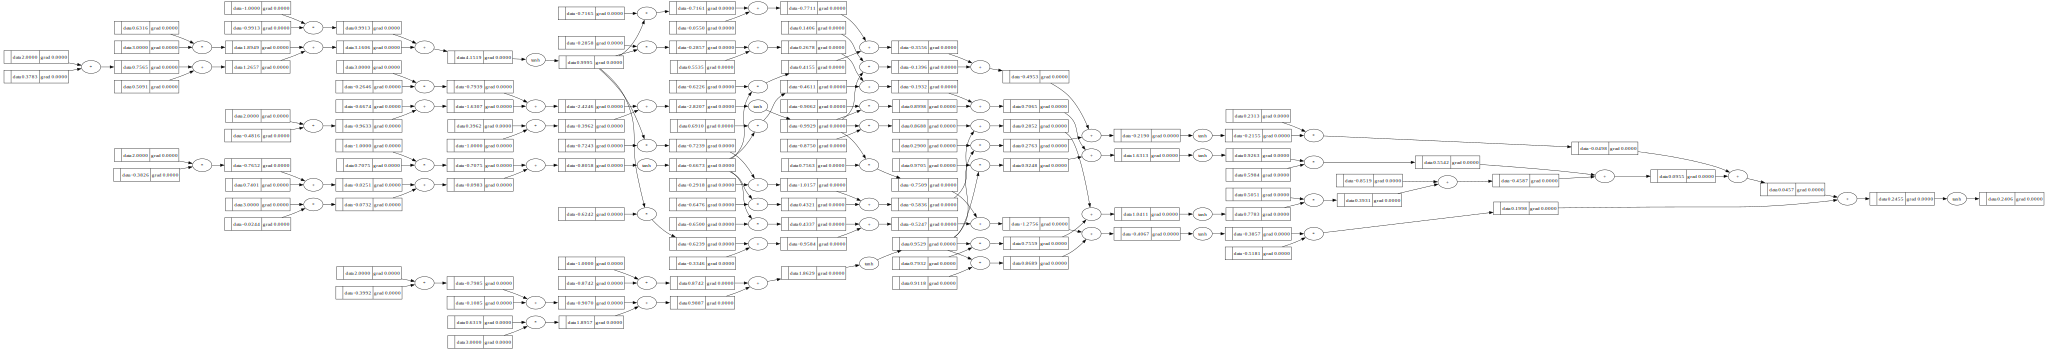

In [437]:
draw_dot(n(x))